# Triplets Final Analysis

Goal: A clean version of the triplets analysis for the paper

## Setup

In [4]:
# Import modules and R
import numpy as np, pandas as pd
from plotnine import *
import pickle
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [5]:
# Import local code
import sys
sys.path.append('../code')
import pcaVersion
from processing_helpers import *
from analysis_helpers import *
from brainspan import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

Attaching package: ‘lemon’



    %||%



    CoordCartesian, element_render




## Triplets 

Move a bunch of this to code file

In [7]:
files = abagen.fetch_microarray(donors='all', data_dir='../data/abagen-data/microarray')
donors = list(files.keys())
donors

['9861', '10021', '12876', '14380', '15496', '15697']

In [8]:
from itertools import combinations
triplets_list = [list(x) for x in list(combinations(range(6), 3))]
triplets_names = [''.join(map(str,x)) for x in triplets_list]
triplets_dict = dict(zip(triplets_names, triplets_list))
triplets_dict_donors = {k:[donors[i] for i in v] for k,v in triplets_dict.items()}
disjoint_triplets = [list(x) for x in combinations(triplets_names,2) if not any(set(list(x[0])).intersection(set(list(x[1]))))]

In [69]:
triplets_hcp = {}
for name, donors in triplets_dict_donors.items():
    expression, stability = get_expression_abagen(fetch_hcp(native=False), donors=donors,
        probe_selection='diff_stability', region_agg='donors',
        lr_mirror='rightleft', #donors_threshold=3, 
        return_stability=True
    )
    triplets_hcp[name] = pcaVersion(expression, message=False)
    triplets_hcp[name].stability = stability

15666 genes remain after filtering for top 1 differential stability
15703 genes remain after filtering for top 1 differential stability
15861 genes remain after filtering for top 1 differential stability
15927 genes remain after filtering for top 1 differential stability
15568 genes remain after filtering for top 1 differential stability
15730 genes remain after filtering for top 1 differential stability
15803 genes remain after filtering for top 1 differential stability
15759 genes remain after filtering for top 1 differential stability
15838 genes remain after filtering for top 1 differential stability
16039 genes remain after filtering for top 1 differential stability
15789 genes remain after filtering for top 1 differential stability
16027 genes remain after filtering for top 1 differential stability
16118 genes remain after filtering for top 1 differential stability
15992 genes remain after filtering for top 1 differential stability
16074 genes remain after filtering for top 1 dif

In [9]:
triplets_3donors_hcp = {}
for name, donors in triplets_dict_donors.items():
    expression, stability = get_expression_abagen(fetch_hcp(native=False), donors=donors,
        probe_selection='diff_stability', region_agg='donors',
        donors_threshold=3, lr_mirror='rightleft',
        return_stability=True
    )
    triplets_3donors_hcp[name] = pcaVersion(expression, message=False)
    triplets_3donors_hcp[name].stability = stability

15666 genes remain after filtering for top 1 differential stability
15703 genes remain after filtering for top 1 differential stability
15861 genes remain after filtering for top 1 differential stability
15927 genes remain after filtering for top 1 differential stability
15568 genes remain after filtering for top 1 differential stability
15730 genes remain after filtering for top 1 differential stability
15803 genes remain after filtering for top 1 differential stability
15759 genes remain after filtering for top 1 differential stability
15838 genes remain after filtering for top 1 differential stability
16039 genes remain after filtering for top 1 differential stability
15789 genes remain after filtering for top 1 differential stability
16027 genes remain after filtering for top 1 differential stability
16118 genes remain after filtering for top 1 differential stability
15992 genes remain after filtering for top 1 differential stability
16074 genes remain after filtering for top 1 dif

In [52]:
triplets_3donors_hcp_native = {}
for name, donors in triplets_dict_donors.items():
    expression, stability = get_expression_abagen(fetch_hcp(native=True), donors=donors,
        probe_selection='diff_stability', region_agg='donors',
        donors_threshold=3, lr_mirror='rightleft',
        return_stability=True
    )
    triplets_3donors_hcp_native[name] = pcaVersion(expression, message=False)
    triplets_3donors_hcp_native[name].stability = stability

15665 genes remain after filtering for top 1 differential stability
15701 genes remain after filtering for top 1 differential stability
15861 genes remain after filtering for top 1 differential stability
15926 genes remain after filtering for top 1 differential stability
15564 genes remain after filtering for top 1 differential stability
15728 genes remain after filtering for top 1 differential stability
15803 genes remain after filtering for top 1 differential stability
15755 genes remain after filtering for top 1 differential stability
15836 genes remain after filtering for top 1 differential stability
16039 genes remain after filtering for top 1 differential stability
15787 genes remain after filtering for top 1 differential stability
16027 genes remain after filtering for top 1 differential stability
16120 genes remain after filtering for top 1 differential stability
15992 genes remain after filtering for top 1 differential stability
16075 genes remain after filtering for top 1 dif

In [20]:
def filter_triplet_ds(triplets, ds_threshold=0):
    triplets_ds = {}
    for name, triplet in triplets.items():
        mask = triplet.stability.rank(pct=True) > ds_threshold
        triplet_expression_ds = triplet.expression.loc[:, mask]
        triplets_ds[name] = pcaVersion(triplet_expression_ds, message=False)
    return triplets_ds

triplets_3donors_hcp_ds8 = filter_triplet_ds(triplets_3donors_hcp, 0.8)

Compare MNI and Native triplets across DS levels

In [100]:
triplets_ds_levels = {}
for ds in [i/10 for i in range(0,10)]:
     triplets_ds_levels[ds] = filter_triplet_ds(triplets_hcp, ds)

In [99]:
# triplets_ds_levels_3donors = triplets_ds_levels
# triplets_ds_levels_native = triplets_ds_levels

In [85]:
data_dir = "~/rds/rds-cam-psych-transc-Pb9UGUlrwWc/Cam_LIBD/AHBA_data/abagen-data/expression/"
hcp_base = pcaVersion(pd.read_csv(data_dir + 'hcp_base.csv', index_col=0))

New PCA version


In [109]:
base = None
# base = hcp_base
match = True

coefs_dict = {name:disjoint_corrs(t, base=base, match=match) for name, t in triplets_ds_levels.items()}
scores_dict = {name:disjoint_corrs(t, base=base, match=match, how='scores') for name, t in triplets_ds_levels.items()}

triplet_versions = (
    pd.concat({'Gene weights': pd.concat(coefs_dict), 'Region scores': pd.concat(scores_dict)})
    .reset_index()
    .rename(columns={'level_0':'how', 'level_1':'version', 'level_2':'component'})
    .assign(component=lambda x: x['component'].replace({i:f'{i+1}' for i in range(5)}))
    .melt(id_vars=['how', 'version', 'component'], var_name='pair', value_name='corr')
    .assign(corr_abs = lambda x: np.abs(x['corr']))
    # .assign(version = lambda x: pd.Categorical(x['version'], categories=x['version'].unique(),ordered=True))
)

MNI

DS levels, no donor filter

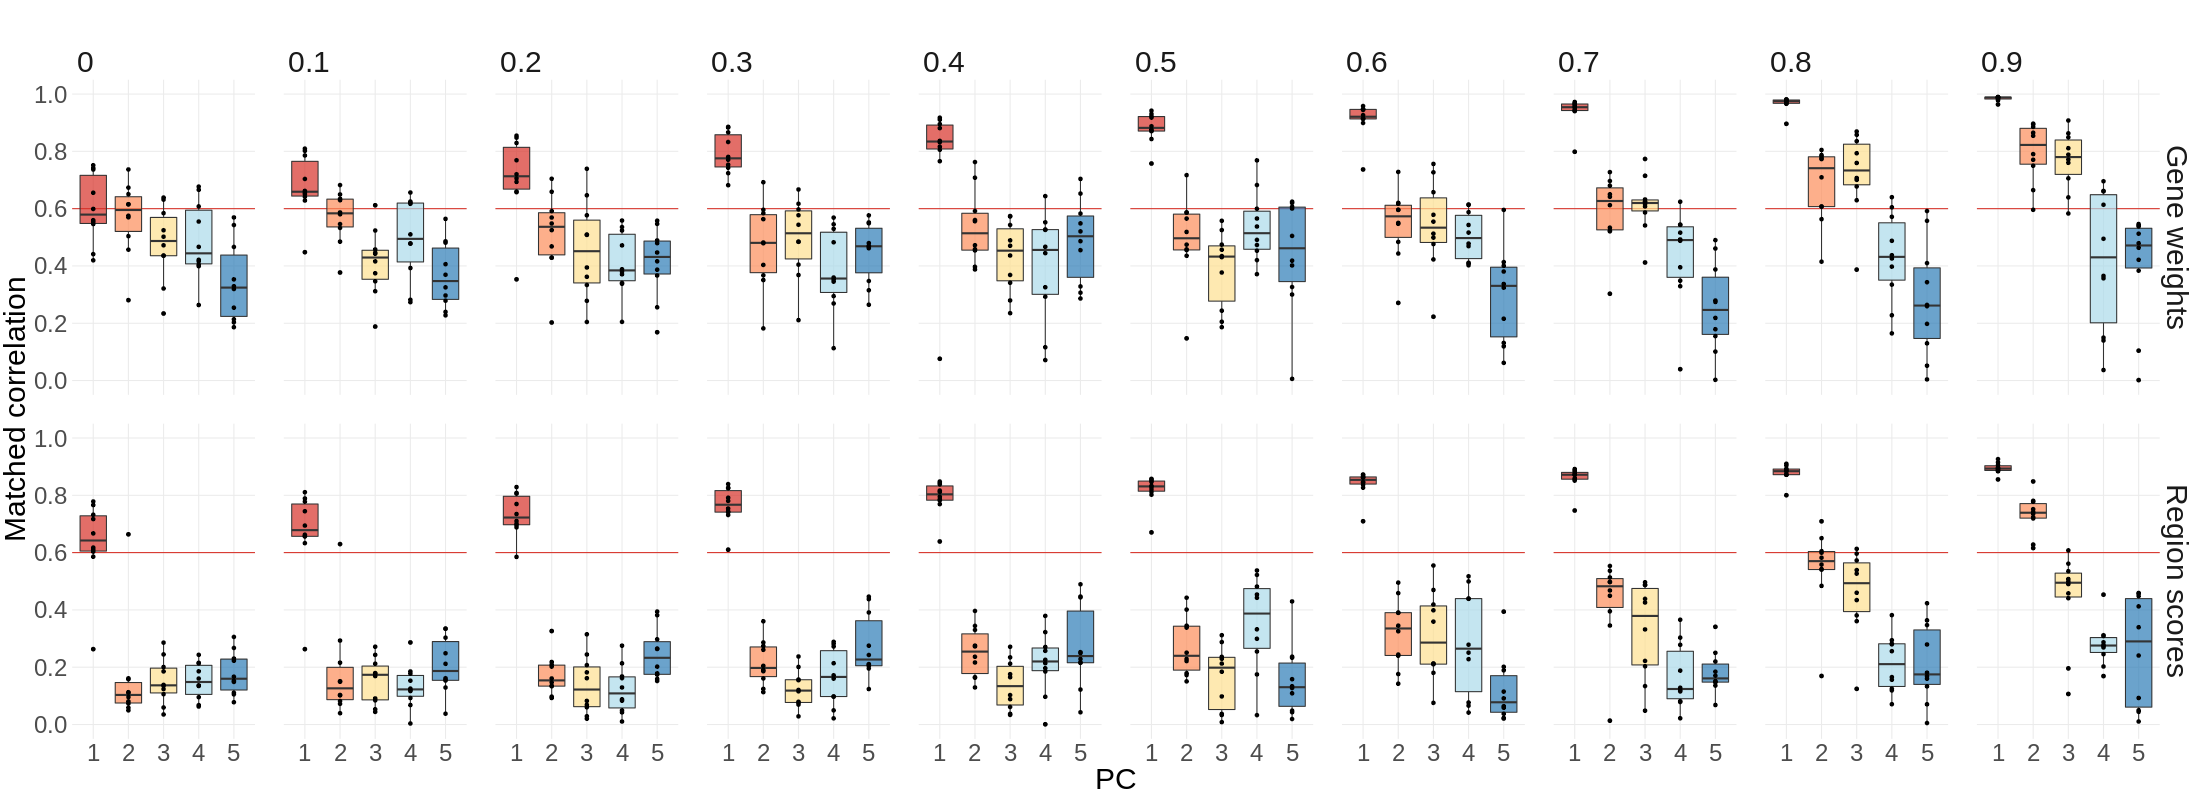

In [110]:
%%R -w 2200 -h 800 -i triplet_versions
source("../code/Rplots.R")
plot_triplets(triplet_versions) & theme(text=element_text(size=30))

3 donor filter

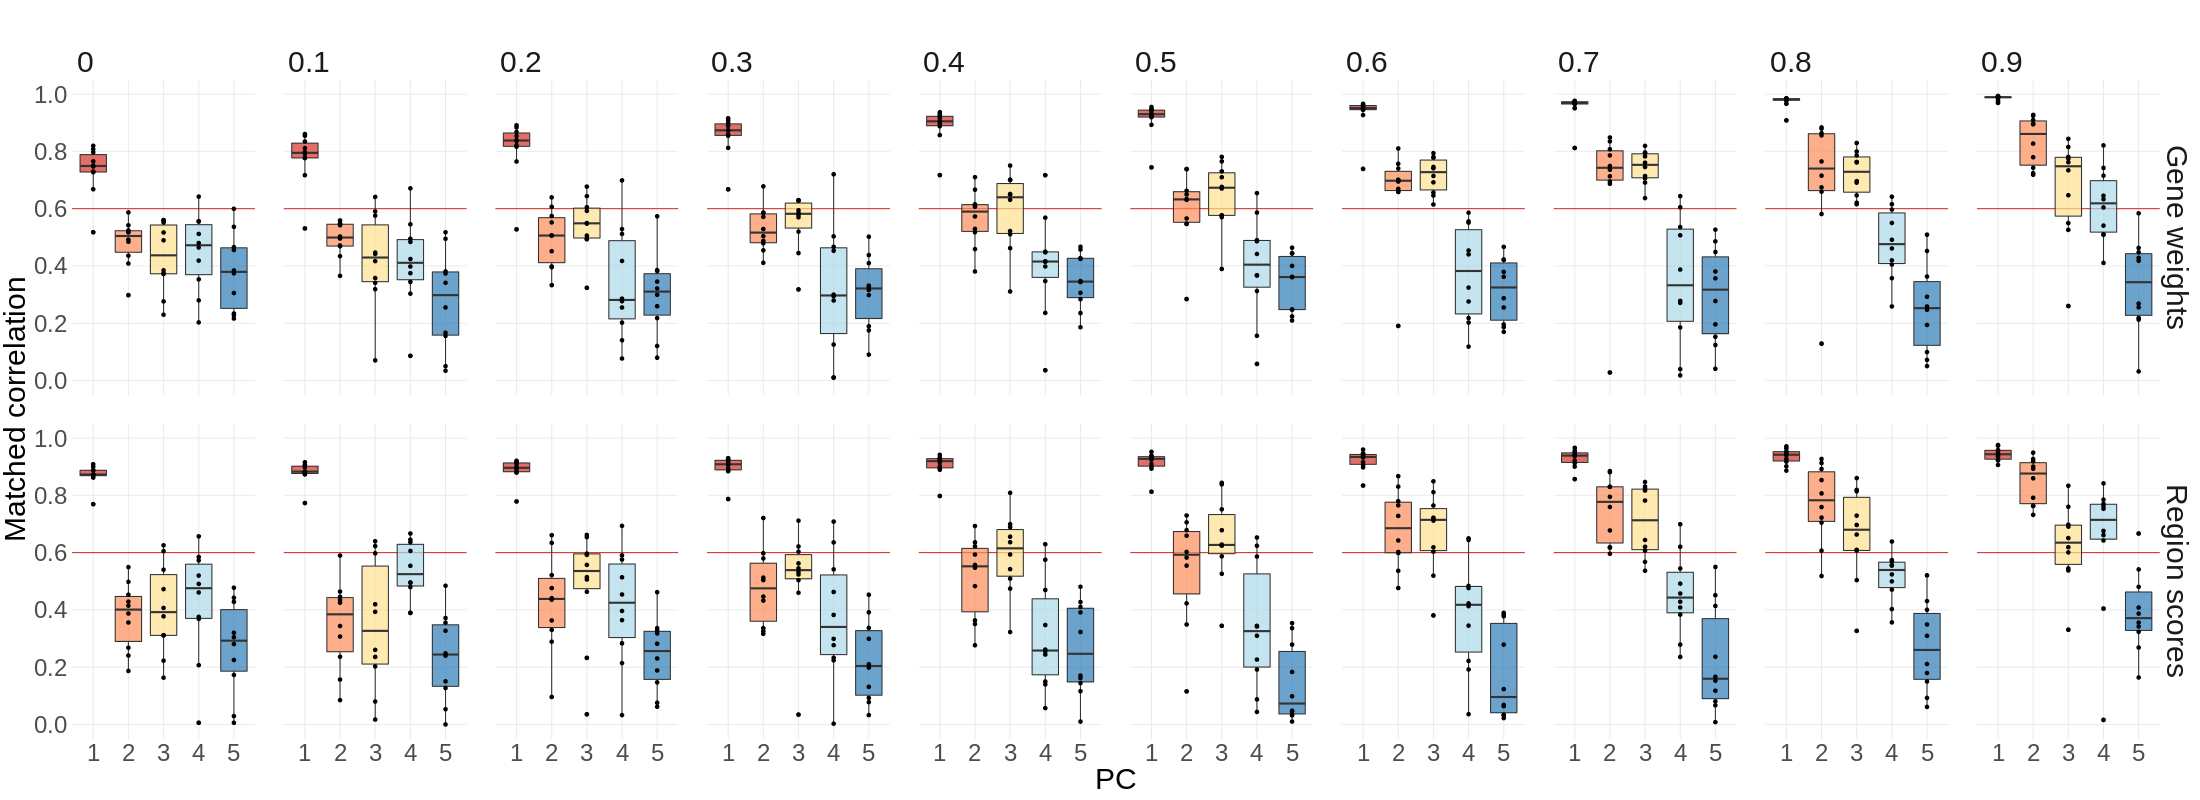

In [94]:
%%R -w 2200 -h 800 -i triplet_versions
source("../code/Rplots.R")
plot_triplets(triplet_versions) & theme(text=element_text(size=30))

Native

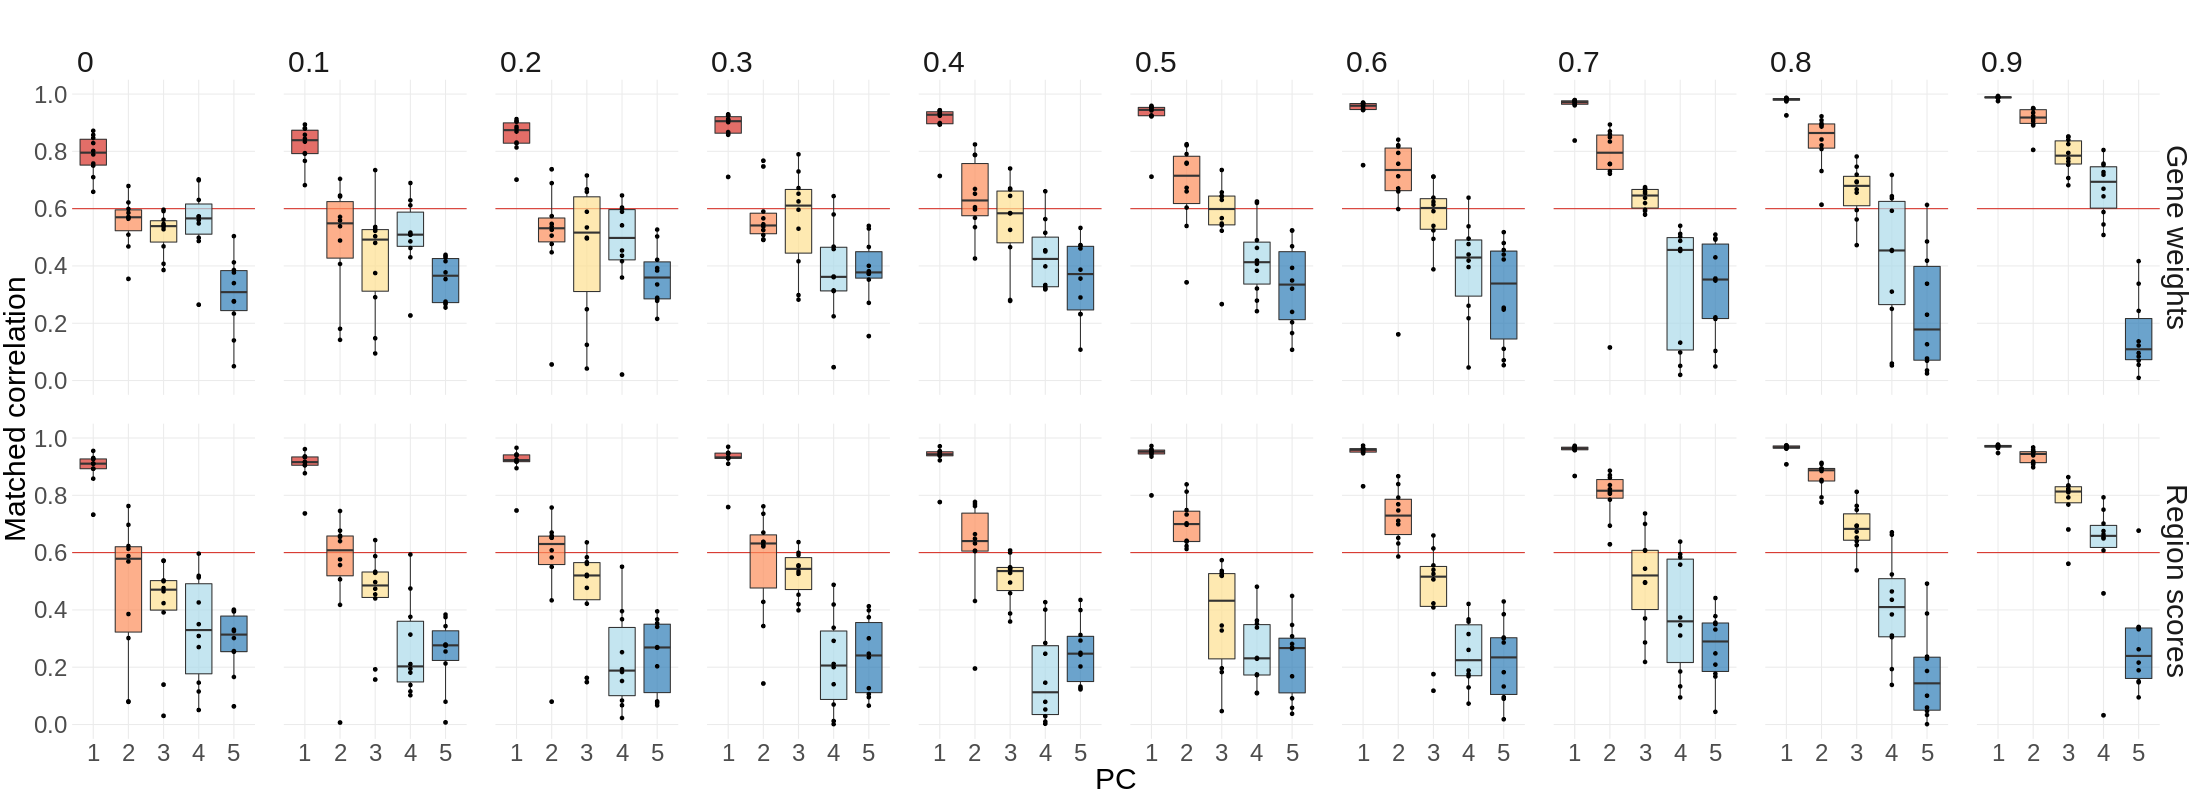

In [68]:
%%R -w 2200 -h 800 -i triplet_versions
source("../code/Rplots.R")
plot_triplets(triplet_versions) & theme(text=element_text(size=30))

Normal triplets analysis

In [70]:
triplets_hcp_ds8 = filter_triplet_ds(triplets_hcp, 0.8)
triplets_3donors_hcp_ds8 = filter_triplet_ds(triplets_3donors_hcp, 0.8)

In [97]:
coefs_dict = {
    'No filters': disjoint_corrs(triplets_hcp),
    'Region filter (3+ donors)': disjoint_corrs(triplets_3donors_hcp),
    # 'Gene filter': disjoint_corrs(triplets_ds7),
    # 'Region & Gene filters': disjoint_corrs(triplets_3donors_ds7),
    'Gene filter (top 20% diff. stab.)': disjoint_corrs(triplets_hcp_ds8),
    'Both region & gene filters': disjoint_corrs(triplets_3donors_hcp_ds8),
}

# base = None
base = hcp_base
scores_dict = {
    'No filters': disjoint_corrs(triplets_hcp, how='scores', base=base),
    'Region filter (3+ donors)': disjoint_corrs(triplets_3donors_hcp, how='scores', base=base),
    # 'Gene filter': disjoint_corrs(triplets_ds7),
    # 'Region & Gene filters': disjoint_corrs(triplets_3donors_ds7),
    'Gene filter (top 20% diff. stab.)': disjoint_corrs(triplets_hcp_ds8, how='scores', base=base),
    'Both region & gene filters': disjoint_corrs(triplets_3donors_hcp_ds8, how='scores', base=base),
}


triplet_versions = (
    pd.concat({'Gene weights':pd.concat(coefs_dict), 'Region scores':pd.concat(scores_dict)})
    .reset_index()
    .rename(columns={'level_0':'how', 'level_1':'version', 'level_2':'component'})
    .assign(component=lambda x: x['component'].replace({i:f'{i+1}' for i in range(5)}))
    .melt(id_vars=['how', 'version', 'component'], var_name='pair', value_name='corr')
    .assign(corr_abs = lambda x: np.abs(x['corr']))
    .assign(version = lambda x: pd.Categorical(x['version'], categories=x['version'].unique(),ordered=True))
)

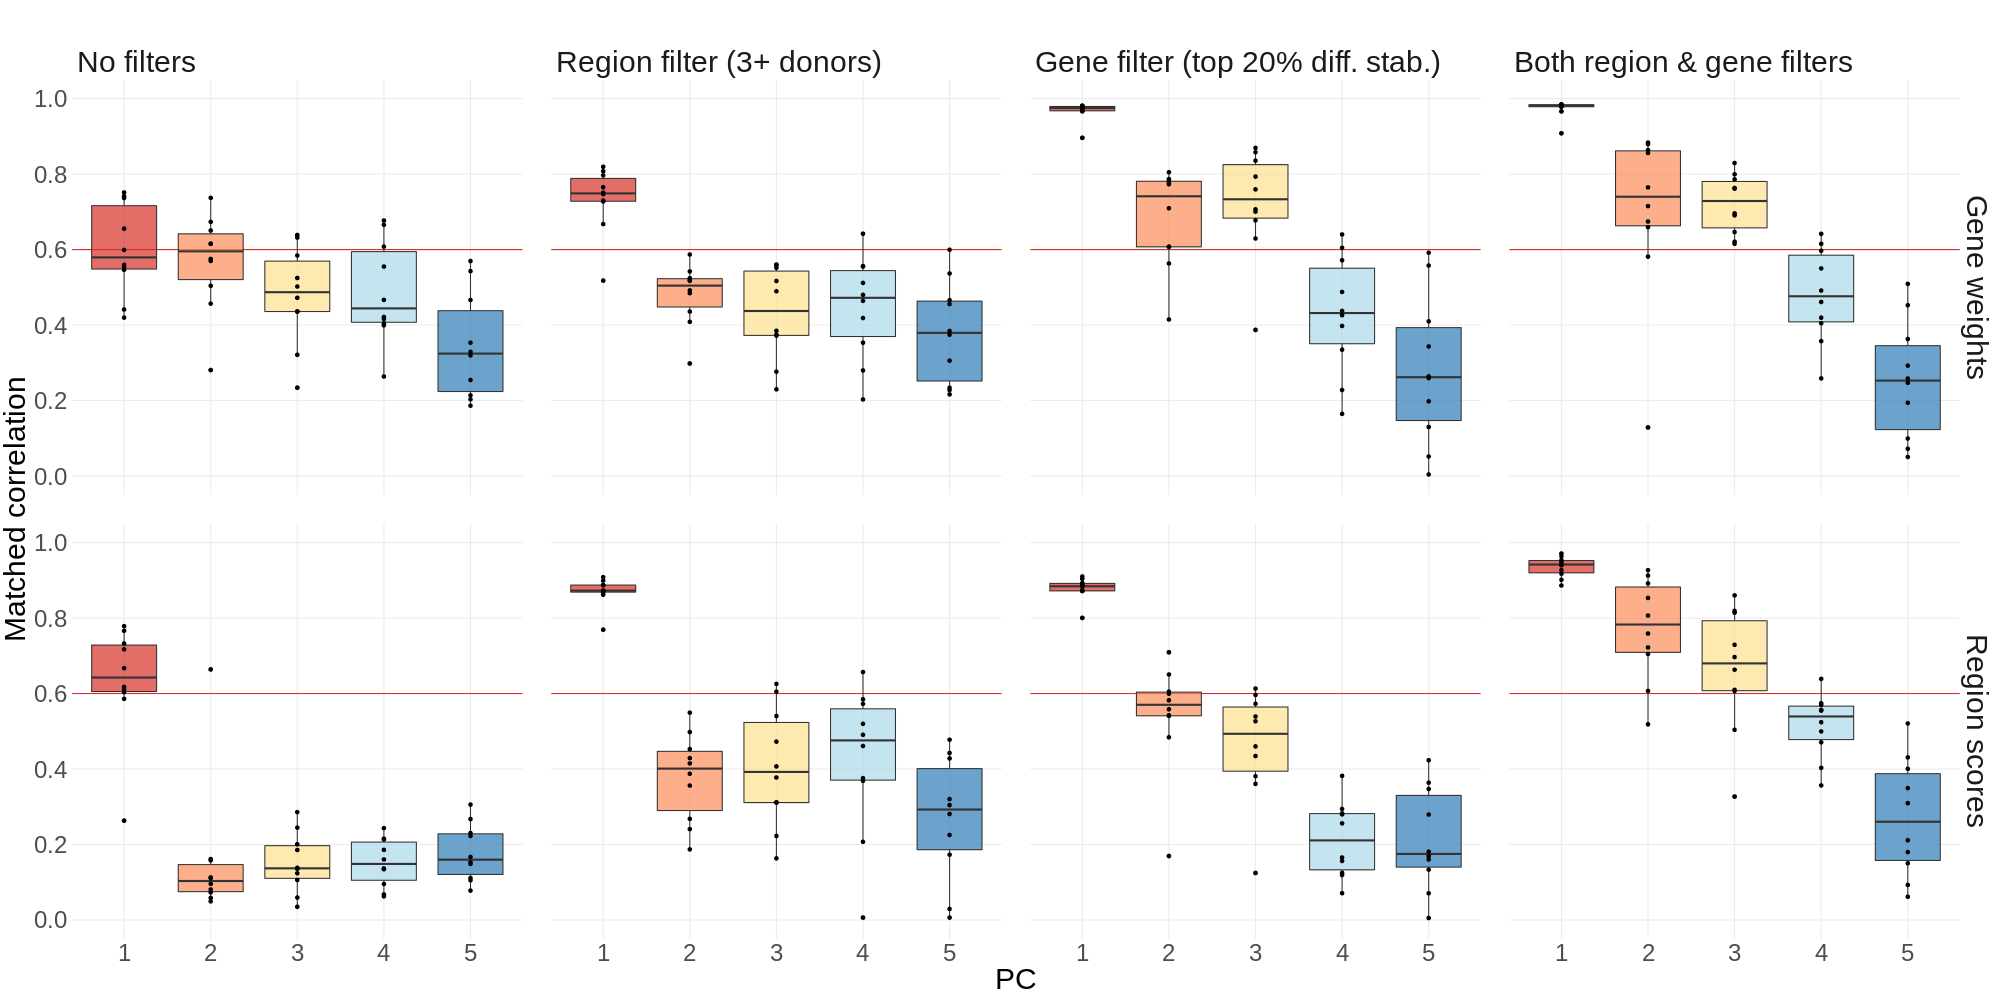

In [74]:
%%R -w 2000 -h 1000 -i triplet_versions
source("../code/Rplots.R")
plot_triplets(triplet_versions) & theme(text=element_text(size=30))

In [80]:
def save_pickle(data, fname):
    with open('../outputs/' + fname + '.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# save_pickle(triplets_hcp, 'triplets_hcp')
save_pickle(triplets_3donors_hcp, 'triplets_3donors_hcp')
save_pickle(triplets_3donors_hcp_native, 'triplets_3donors_hcp_native')

In [78]:
def load_pickle(fname):
    with open('../outputs/' + fname + '.pickle', 'rb') as handle:
        return pickle.load(handle)

triplets_hcp = load_pickle('triplets_hcp')